# <span style="color:#0F19C9">Contents</span>

- [Introduction](#introduction)
- [Importing libraries and data](#importing-libraries-and-data)
- [Create train and test dataframe](#create-train-and-test-dataframe)
- [Training model](#training-model)
- [Build the submission dataframe](#build-the-submission-dataframe)

# <span style="color:#0F19C9">Introduction</span>

The idea of this notebook consist of building a model with a training data of prior orders of Instacart that give us a prediction of the products that is going to be in the next order for every user. We created the tran dataframe from the data proporcioned by InstaCart which contains users info, products info, orders, and others.

We are going to built a classification model that predict if one user is going to reorder one product.

# <span style="color:#0F19C9">Importing libraries and data</span>

We import `Pandas` for the dataframe management, `os` for file managing in our local system, `numpy` for its linear algebra capabilities, `Pyplot` to built the different visualizations we need and some `SciKit Learn` packages to preprocess, building and studying the model.

In [32]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

In [33]:
# Show all columns
pd.set_option('display.max_columns', None)

# Import my color palette
juan_colors = ['#101B4B', '#545E85', '#A3A8B2',
               '#E7E7E7', '#0F19C9', '#F6D673']

# Crear la paleta de colores personalizada
colors = [juan_colors[5], juan_colors[0]]
juan_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Setting plot font
plt.rc('font', family='Georgia', size=12)

In [34]:
# Load final main dataframe
files_folder = '../Data/Processed/'
df = pd.concat([
    pd.read_csv(f'{files_folder}{file}') for file in os.listdir(files_folder)
])

# Load raw files
df_orders = pd.concat([
    pd.read_csv(f'../Data/Raw/{file}') for file in ['orders_1.csv', 'orders_2.csv']
])
df_order_products_train = pd.read_csv('../Data/Raw/order_products__train.csv')

In [35]:
# Filter my needed orders
df_orders.columns = [column.title() for column in df_orders.columns]
df_order_products_train.columns = [
    column.title() for column in df_order_products_train.columns]
my_orders = df_orders[(df_orders['Eval_Set'] == 'train')
                      | (df_orders['Eval_Set'] == 'test')]

# Add the columns to main dataframe
df = df.merge(my_orders,
              on='User_Id',
              how='left')

# Delete temportal variables
del my_orders

# <span style="color:#0F19C9">Create train and test dataframe</span>

In [36]:
# Filter main dataframe
df_train = df[df['Eval_Set'] == 'train']

# Merge 'Order Products'
df_train = df_train \
    .merge(df_order_products_train,
           on=['Product_Id', 'Order_Id'],
           how='left')

# Clean df_train
df_train.drop(['Order_Id', 'Eval_Set',
               'Add_To_Cart_Order'],
              axis=1, inplace=True)
df_train.fillna(0, inplace=True)

In [37]:
# Filter main dataframe
df_test = df[df['Eval_Set'] == 'test']

# Clear df_test
df_test = df_test.drop(['Order_Id', 'Eval_Set'],
                       axis=1) \
    .fillna(0)

In [38]:
# Reindex dataframes
df_test = df_test.set_index(['User_Id', 'Product_Id'])
df_train = df_train.set_index(['User_Id', 'Product_Id'])

# Delete temporal variables
del [df,
     df_order_products_train,
     files_folder]

# <span style="color:#0F19C9">Training model</span>

In [39]:
# Define features and target
features_train = df_train.drop('Reordered', axis=1)
target_train = df_train['Reordered']

# Divide train and test dataframe
features_train, features_valid, target_train, target_valid = train_test_split(features_train,
                                                                              target_train,
                                                                              test_size=0.3,
                                                                              random_state=42)

# Create and train the model
regression = LogisticRegression(max_iter=1000)
regression.fit(features_train, target_train)

LogisticRegression(max_iter=1000)

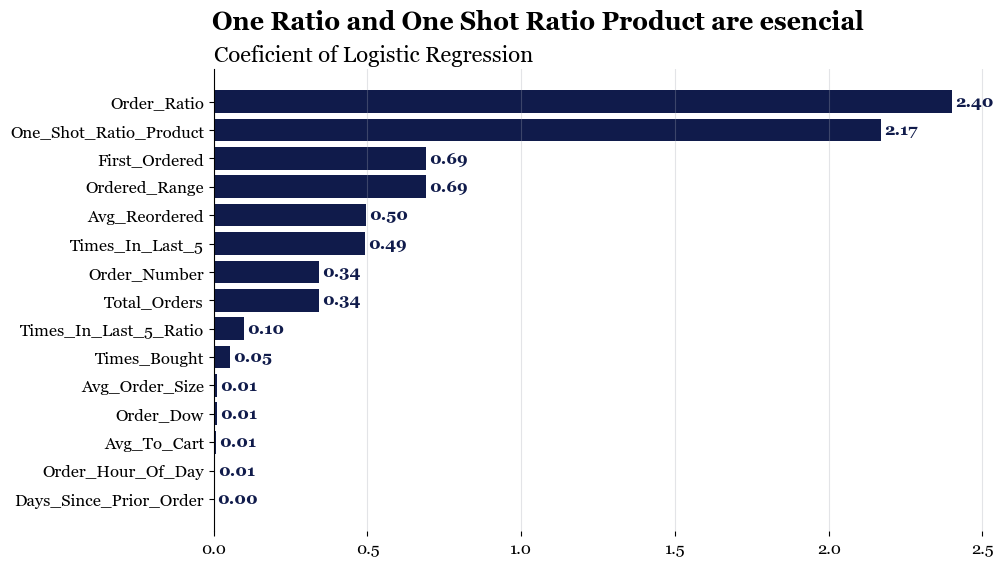

In [40]:
# Get feature importance
feature_importance = pd.DataFrame({
    'Feature_Name': regression.feature_names_in_,
    'Importance': np.absolute(regression.coef_[0])}) \
    .sort_values(by='Importance')

# Crear el gráfico de barras horizontal
fig, ax = plt.subplots(figsize=(10, 6))
plt.suptitle('One Ratio and One Shot Ratio Product are esencial',
             ha='left', size=18, weight='bold',
             x=0.123, y=0.98)
plt.title('Coeficient of Logistic Regression',
          loc='left', size=16)
bars = plt.barh(y='Feature_Name',
                width='Importance',
                data=feature_importance,
                color=juan_colors[0])
for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
            f'{width:.2f}', ha='left', va='center',
            color=juan_colors[0], weight='semibold')
plt.grid(color=juan_colors[2],
         axis='x', alpha=0.3)
ax.spines[['top', 'bottom', 'right']].set_visible(False)
plt.show()

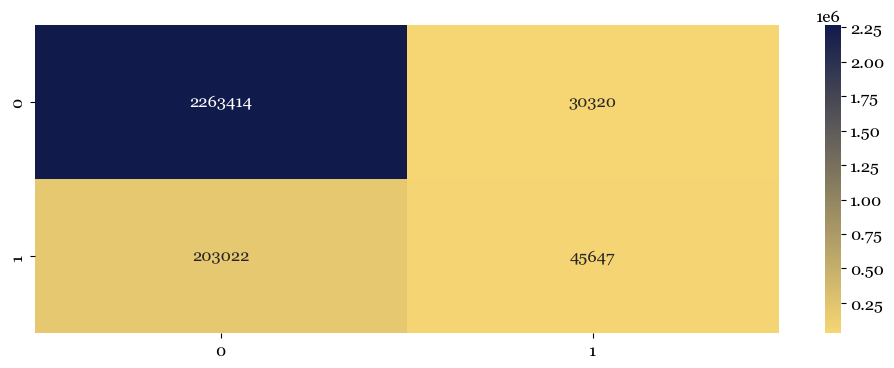

The accuracy score is: 0.9082
The f1 score is: 0.2812


In [41]:
# Find predictions to validate
predictions = regression.predict(features_valid)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=[12, 4])
sns.heatmap(confusion_matrix(target_valid, predictions),
            cmap=juan_cmap, annot=True,
            fmt='.0f', ax=ax)
plt.show()

print(
    f'The accuracy score is: {accuracy_score(target_valid, predictions):.4f}')
print(f'The f1 score is: {f1_score(target_valid, predictions):.4f}')

# <span style="color:#0F19C9">Build the submission dataframe</span>

In [86]:
# Merge with order test
test_orders = df_orders[df_orders['Eval_Set']
                        == 'test'][['User_Id', 'Order_Id']]
df_pivot = df_test.reset_index()[['Product_Id', 'User_Id']]
df_pivot['Product_Id'] = df_pivot['Product_Id'].astype(int)
df_pivot['Prediction'] = regression.predict(df_test)
df_pivot['Prediction'] = df_pivot['Prediction']
df_pivot = df_pivot \
    .merge(test_orders, on='User_Id',
           how='left') \
    .drop('User_Id', axis=1)

# Create de submission dataframe
submission = df_pivot.groupby('Order_Id')['Product_Id'].apply(list).to_frame()
submission['Boolean'] = df_pivot.groupby('Order_Id')['Prediction'].apply(list)

In [88]:
def filter_products(row):
    # Función para filtrar productos basados en la lista de booleanos
    products = row['Product_Id']
    booleans = row['Boolean']
    return [product for product, flag in zip(products, booleans) if flag == 1]

In [89]:
# Crear la nueva columna 'Products'
submission['Products'] = submission \
    .apply(filter_products, axis=1)
submission = submission.reset_index()[['Order_Id', 'Products']]
submission.to_csv('../Data/Processed/submission.csv',
                  index=False)

# Mostrar 5 registros aleatorios
submission.sample(5)

,Order_Id,Products
39108,1784201,[]
25679,1168419,"[5876, 7969, 16797, 27344, 47209, 49235]"
42513,1941738,"[10478, 24852, 27037, 32478, 40534, 43352, 48335]"
41538,1895055,[]
59312,2706434,"[4472, 27336, 49235]"
